# End-to-End Multimodal RAG System

**Authors:** Bayu Ardiyansyah | **Date:** Nov 2025 | **Course:** Image Retrival Final Project

### **Abstract**

Notebook ini mengimplementasikan sistem *Multimodal Retrieval Augmented Generation* (RAG) secara *end-to-end*. Sistem menggabungkan **CLIP (Contrastive Language-Image Pretraining)** untuk ekstraksi fitur semantik, **FAISS** untuk pencarian vektor berkecepatan tinggi, **BLIP-2** untuk *image captioning* otomatis, dan **Llama-3** (via Ollama) untuk penalaran kontekstual. Arsitektur ini dirancang untuk menyelesaikan masalah "kebutaan visual" pada LLM tradisional.

### **0. Setup Lingkungan & Konfigurasi Global**

Inisialisasi pustaka *Deep Learning* (PyTorch, Transformers), manajemen memori GPU, dan konfigurasi *path* dataset sesuai struktur direktori proyek.

In [5]:
# @title 1. Configuration, Enhanced Encoder & System Verification (ANTI-REBUILD)
import os
import torch
import numpy as np
import requests
import pandas as pd
import time
import faiss 
from typing import List, Union
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

class Config:
    # --- 1. PATH SETTINGS ---
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    BASE_DIR = PROJECT_ROOT
    IMAGES_DIR = "../Dataset/Images"
    CAPTIONS_FILE = "../Dataset/captions.txt"
    
    INDEX_PATH = "flickr30k_large.index"      
    METADATA_PATH = "metadata_large.json"
    
    # --- 2. SYSTEM SETTINGS ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TOP_K = 5
    BATCH_SIZE = 16
    
    # --- 3. RETRIEVAL MODEL (Default Awal) ---
    RETRIEVAL_MODEL = "openai/clip-vit-large-patch14" 
    
    # --- 4. GENERATIVE CONFIG ---
    CAPTION_MODEL = "Salesforce/blip2-opt-2.7b" 
    
    # --- 5. OLLAMA CONFIG (LOCAL WSL) ---
    OLLAMA_HOST = "localhost" 
    OLLAMA_PORT = 11434
    LLM_API = f"http://{OLLAMA_HOST}:{OLLAMA_PORT}/api/generate"
    LLM_MODEL = "llama3"
    
    OLLAMA_TIMEOUT_CONNECT = 10
    OLLAMA_TIMEOUT_GENERATE = 120 

print("-" * 60)
print("🕵️ SMART INDEX DETECTION (Anti-Rebuild Logic)")

if os.path.exists(Config.INDEX_PATH):
    try:
        temp_index = faiss.read_index(Config.INDEX_PATH)
        disk_dim = temp_index.d
        print(f"   📂 Found existing index file: {Config.INDEX_PATH}")
        print(f"   📏 Disk Index Dimension: {disk_dim}")
        
        # Ubah Config secara otomatis agar sesuai dengan Harddisk
        if disk_dim == 512:
            print("   ⚡ DECISION: Disk has 512-dim. Switching Config to 'CLIP-BASE'.")
            Config.RETRIEVAL_MODEL = "openai/clip-vit-base-patch32"
        elif disk_dim == 768:
            print("   🚀 DECISION: Disk has 768-dim. Keeping Config as 'CLIP-LARGE'.")
            Config.RETRIEVAL_MODEL = "openai/clip-vit-large-patch14"
            
    except Exception as e:
        print(f"   ⚠️ Error checking index: {e}. Using default config.")
else:
    print("   🆕 No index found. Will use default config.")
print("-" * 60)
# ==============================================================================


class VisualEncoder:
    def __init__(self, model_name: str, device: str):
        self.device = device
        print(f"--> Initializing High-Performance Model: {model_name}")
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
    def embed_images(self, image_paths: List[str]) -> np.ndarray:
        images = []
        for idx, p in enumerate(image_paths):
            try:
                full_path = os.path.abspath(p) if not os.path.isabs(p) else p
                img = Image.open(full_path).convert("RGB") 
                images.append(img)
            except Exception as e: 
                continue
            
        # Dinamis return empty sesuai model yang aktif
        target_dim = 768 if "large" in Config.RETRIEVAL_MODEL else 512
        if not images: return np.empty((0, target_dim))
        
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            features = self.model.get_image_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True) 
        return features.cpu().numpy()

    def embed_text(self, text: Union[str, List[str]]) -> np.ndarray:
        if isinstance(text, str): text = [text]
        text_with_prompt = [f"A photo of {t}" for t in text]
        inputs = self.processor(text=text_with_prompt, return_tensors="pt", padding=True, truncation=True, max_length=77).to(self.device)
        with torch.no_grad():
            features = self.model.get_text_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
        return features.cpu().numpy()


# ============================================
# OLLAMA HELPER FUNCTIONS
# ============================================

def check_ollama_connection(timeout: int = None) -> bool:
    if timeout is None: timeout = Config.OLLAMA_TIMEOUT_CONNECT
    try:
        base_url = f"http://{Config.OLLAMA_HOST}:{Config.OLLAMA_PORT}"
        response = requests.get(base_url, timeout=timeout)
        return response.status_code == 200
    except:
        return False

def force_server_refresh():
    try:
        pull_url = f"http://{Config.OLLAMA_HOST}:{Config.OLLAMA_PORT}/api/pull"
        payload = {"name": Config.LLM_MODEL, "stream": False}
        print(f"   ⚡ Sending Wake-Up Call to Local Server for '{Config.LLM_MODEL}'...")
        requests.post(pull_url, json=payload, timeout=120)
        time.sleep(1)
    except:
        pass

def list_ollama_models(timeout: int = None) -> list:
    if timeout is None: timeout = Config.OLLAMA_TIMEOUT_CONNECT
    try:
        api_tags = f"http://{Config.OLLAMA_HOST}:{Config.OLLAMA_PORT}/api/tags"
        response = requests.get(api_tags, timeout=timeout)
        if response.status_code == 200:
            data = response.json()
            return data.get('models', [])
    except:
        pass
    return []

def test_ollama_model(model_name: str, prompt: str = "Hello", timeout: int = None) -> tuple:
    if timeout is None: timeout = Config.OLLAMA_TIMEOUT_GENERATE
    try:
        payload = {"model": model_name, "prompt": prompt, "stream": False}
        response = requests.post(Config.LLM_API, json=payload, timeout=timeout)
        if response.status_code == 200:
            return (True, response.json().get('response', ''))
        else:
            return (False, f"Status {response.status_code}")
    except Exception as e:
        return (False, str(e))

# --- INITIALIZATION ---
encoder = VisualEncoder(Config.RETRIEVAL_MODEL, Config.DEVICE)

print("\n" + "="*70)
print("🔍 SYSTEM VERIFICATION CHECK")
print("="*70)

# 1. Runtime & Data Check
print(f"✅ Device Runtime : {Config.DEVICE.upper()}")
img_abs_path = os.path.abspath(Config.IMAGES_DIR)

if os.path.exists(img_abs_path):
    num = len([f for f in os.listdir(img_abs_path) if f.endswith(('.jpg', '.png'))])
    print(f"✅ Image Dataset  : FOUND ({num} images)")
else:
    print(f"❌ Image Dataset  : NOT FOUND")

# 2. Ollama Check (LOCAL)
print(f"\n{'─'*70}")
print(f"🤖 OLLAMA SERVER CHECK (Localhost Mode)")
print(f"{'─'*70}")

if check_ollama_connection():
    print(f"✅ Connection     : SUCCESS (Localhost connected)")
    
    # Cek Model
    models = list_ollama_models()
    
    if not models:
        print(f"⚠️  Models Found   : 0 (Checking if server is just shy...)")
        force_server_refresh()
        models = list_ollama_models()
        
    if models:
        print(f"✅ Models Found   : {len(models)}")
        available_names = [m.get('name') for m in models]
        
        target_found = False
        for name in available_names:
            if Config.LLM_MODEL in name:
                target_found = True
                Config.LLM_MODEL = name
                break
        
        if not target_found:
             print(f"⚠️  Target '{Config.LLM_MODEL}' not found in local list.")
             print(f"   Available: {available_names}")
             Config.LLM_MODEL = available_names[0]
             print(f"   👉 Switching to: '{Config.LLM_MODEL}'")

        print(f"\n   Testing Inference with '{Config.LLM_MODEL}'...")
        print(f"   (Waiting up to {Config.OLLAMA_TIMEOUT_GENERATE} seconds for model loading...)")
        
        success, response = test_ollama_model(Config.LLM_MODEL, timeout=Config.OLLAMA_TIMEOUT_GENERATE)
        
        if success:
            print(f"✅ Model Test     : PASSED")
            print(f"   Response       : {response.strip()[:50]}...")
        else:
            print(f"❌ Model Test     : FAILED ({response})")
    else:
        print("❌ No models found. Did you run 'ollama pull llama3' INSIDE WSL terminal?")
else:
    print(f"❌ Connection     : FAILED")
    print(f"   👉 Make sure to run 'ollama serve' inside your WSL terminal!")

print("="*70)

------------------------------------------------------------
🕵️ SMART INDEX DETECTION (Anti-Rebuild Logic)
   📂 Found existing index file: flickr30k_large.index
   📏 Disk Index Dimension: 512
   ⚡ DECISION: Disk has 512-dim. Switching Config to 'CLIP-BASE'.
------------------------------------------------------------
--> Initializing High-Performance Model: openai/clip-vit-base-patch32

🔍 SYSTEM VERIFICATION CHECK
✅ Device Runtime : CUDA
✅ Image Dataset  : FOUND (31783 images)

──────────────────────────────────────────────────────────────────────
🤖 OLLAMA SERVER CHECK (Localhost Mode)
──────────────────────────────────────────────────────────────────────
✅ Connection     : SUCCESS (Localhost connected)
✅ Models Found   : 1

   Testing Inference with 'llama3:latest'...
   (Waiting up to 120 seconds for model loading...)
✅ Model Test     : PASSED
   Response       : Hello! It's nice to meet you. Is there something I...


### **Komponen 1: Dataset (Data Ingestion & Cleaning)**

**Sesuai Penugasan Poin 1:** *Dataset (Flickr30k/Dataset Publik)*.

**Deskripsi:**
Modul ini menangani pemuatan metadata `captions.txt`, pembersihan nama kolom, dan verifikasi integritas fisik file gambar di disk untuk mencegah *runtime error* saat *embedding*.

In [2]:
# @title Komponen 1: Dataset Loading & Integrity Check
class DatasetManager:
    """
    Bertanggung jawab untuk memuat data mentah dan memvalidasi keberadaan aset fisik.
    """ 
    def __init__(self, csv_path: str, img_dir: str):
        self.csv_path = csv_path
        self.img_dir = img_dir
        
    def load_and_verify(self) -> pd.DataFrame:
        print("--> Loading dataset metadata...")
        # Membaca CSV dengan separator koma, menangani potensi error parsing
        df = pd.read_csv(self.csv_path, on_bad_lines='skip')
        
        # Normalisasi nama kolom (menghapus spasi berlebih)
        df.columns = [c.strip() for c in df.columns]
        
        # Deduplikasi: Kita hanya butuh daftar file unik untuk di-embed
        unique_files = df['image'].drop_duplicates().tolist()
        
        valid_files = []
        print(f"--> Verifying {len(unique_files)} unique images on disk...")
        
        for img in tqdm(unique_files):
            if os.path.exists(os.path.join(self.img_dir, img)):
                valid_files.append(img)
            else:
                # Log gambar yang hilang (opsional)
                pass
                
        print(f"✅ Valid Images Ready for Indexing: {len(valid_files)}")
        return pd.DataFrame(valid_files, columns=['image_filename'])

# Eksekusi
dataset_mgr = DatasetManager(Config.CAPTIONS_FILE, Config.IMAGES_DIR)
df_images = dataset_mgr.load_and_verify()

--> Loading dataset metadata...
--> Verifying 31783 unique images on disk...


100%|██████████| 31783/31783 [00:57<00:00, 554.44it/s]


✅ Valid Images Ready for Indexing: 31783


### **Komponen 2: Feature Extraction / Embedding**

**Sesuai Penugasan Poin 2:** *Gunakan model pretrained (CLIP) & Simpan di FAISS*.

**Deskripsi:**
Mengimplementasikan *class* `VisualEncoder` yang membungkus model **CLIP (ViT-B/32)**. Fungsi utamanya adalah memproyeksikan citra dan teks ke dalam ruang vektor (latent space) yang sama, serta melakukan normalisasi L2 agar siap untuk perhitungan *Cosine Similarity*.

In [3]:
# @title Komponen 2: Feature Extraction (Optimization Upgrade)
class VisualEncoder:
    def __init__(self, model_name: str, device: str):
        self.device = device
        print(f"--> Initializing SOTA Model: {model_name}")
        # Menggunakan CLIPProcessor standar
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
    def embed_images(self, image_paths: List[str]) -> np.ndarray:
        images = []
        valid_indices = []
        
        # Load images dengan handling yang aman
        for idx, p in enumerate(image_paths):
            try:
                # Pastikan convert RGB agar tidak error pada gambar Grayscale/CMYK
                img = Image.open(p).convert("RGB")
                images.append(img)
                valid_indices.append(idx)
            except Exception as e:
                continue
            
        if not images: return np.empty((0, 512))
        
        # PREPROCESSING: Padding=True dan Truncation=True penting!
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)
        
        with torch.no_grad():
            features = self.model.get_image_features(**inputs)
            # CRITICAL: Normalisasi L2 untuk Cosine Similarity
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            
        return features.cpu().numpy()

    def embed_text(self, text: Union[str, List[str]]) -> np.ndarray:
        # Support input string tunggal atau list
        if isinstance(text, str): text = [text]
        
        # PREPROCESSING: Padding & Truncation agar teks panjang tidak error
        inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=77).to(self.device)
        
        with torch.no_grad():
            features = self.model.get_text_features(**inputs)
            # CRITICAL: Normalisasi L2
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            
        return features.cpu().numpy()

# Re-Initialize (Gunakan model yang lebih besar jika VRAM cukup, misal: ViT-L/14)
# Untuk tugas ini kita tetap pakai base tapi dengan preprocessing yang diperbaiki
encoder = VisualEncoder("openai/clip-vit-base-patch32", Config.DEVICE)

--> Initializing SOTA Model: openai/clip-vit-base-patch32


### **Komponen 2.5: (Optional) Fine-Tuning BLIP-2 dengan QLoRA**

**Tujuan:**
Bagian ini bersifat opsional. Tujuannya adalah melatih ulang (fine-tune) model BLIP-2 menggunakan dataset Flickr30k yang kita miliki agar model lebih memahami gaya bahasa dan konteks spesifik dari dataset ini.

**Metode:**
Karena keterbatasan VRAM (8GB), kita menggunakan teknik **QLoRA (Quantized Low-Rank Adaptation)** dengan presisi **4-bit**.
- **Quantization:** Model dimuat dalam 4-bit untuk menghemat memori drastis.
- **LoRA:** Hanya melatih < 1% parameter tambahan (adapter), bukan seluruh model.
- **Gradient Checkpointing:** Menghemat memori saat training dengan sedikit mengorbankan kecepatan.

In [9]:
import os
import torch
import pandas as pd
import gc
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model
from tqdm.notebook import tqdm

# Konfigurasi Training dan Hyperparameter
class TrainingConfig:
    """
    Menyimpan seluruh konfigurasi untuk proses fine-tuning.
    Disesuaikan untuk VRAM 8GB dengan strategi Gradient Accumulation.
    """
    # Batch size 1 wajib digunakan untuk menghindari Out-Of-Memory (OOM)
    BATCH_SIZE = 1          
    
    # Akumulasi gradien sebanyak 8 langkah. 
    # Efektifnya, model belajar seolah-olah batch size = 8 (1 * 8).
    GRAD_ACCUMULATION = 8   
    
    # Jumlah epoch. 1 epoch (~3800 langkah update) sudah cukup untuk domain adaptation
    # tanpa merusak pengetahuan umum model (catastrophic forgetting).
    EPOCHS = 1              
    
    # Learning rate standar untuk LoRA. 
    # Jangan terlalu tinggi agar bobot tidak berubah drastis.
    LEARNING_RATE = 1e-4    
    
    # Panjang maksimal token caption. 
    MAX_LENGTH = 40         
    
    # ID Model dari HuggingFace
    MODEL_ID = "Salesforce/blip2-opt-2.7b"
    
    # Folder output penyimpanan adapter LoRA
    OUTPUT_DIR = "../fine_tuned_blip2_adapter"
    
    # Deteksi otomatis GPU
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Path dataset lokal
    CAPTIONS_FILE = "../Dataset/captions.txt" 
    IMAGE_DIR = "../Dataset/Images/"

print(f"[INFO] Konfigurasi dimuat. Target Device: {TrainingConfig.DEVICE}")


# Definisi Dataset Wrapper
class FlickrFineTuneDataset(Dataset):
    """
    Kelas Dataset kustom untuk memuat pasangan gambar dan caption dari Flickr30k.
    Menangani pembacaan file gambar dan tokenisasi teks.
    """
    def __init__(self, caption_file, image_dir, processor):
        self.image_dir = image_dir
        self.processor = processor
        try:
            self.df = pd.read_csv(caption_file)
            # Fallback jika header CSV tidak standar
            if 'image' not in self.df.columns: 
                self.df = pd.read_csv(caption_file, names=['image', 'caption'], header=0)
        except Exception as e:
            print(f"[ERROR] Gagal memuat CSV: {e}")
            self.df = pd.DataFrame()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Mengambil nama file dan caption dari DataFrame
        img_name = self.df.iloc[idx, 0]
        caption = str(self.df.iloc[idx, 1])
        img_path = os.path.join(self.image_dir, img_name)

        # Memuat gambar dan konversi ke RGB (mencegah error pada gambar grayscale/RGBA)
        try:
            image = Image.open(img_path).convert("RGB")
        except:
            # Menggunakan gambar placeholder hitam jika file rusak/hilang
            image = Image.new('RGB', (224, 224), color='black')

        # Tokenisasi menggunakan processor bawaan BLIP-2
        encoding = self.processor(
            images=image, 
            text=caption, 
            padding="max_length", 
            return_tensors="pt",
            max_length=TrainingConfig.MAX_LENGTH,
            truncation=True
        )
        
        # Menghapus dimensi batch ekstra (misal [1, 3, 224, 224] -> [3, 224, 224])
        # Ini diperlukan karena DataLoader akan menambahkan dimensi batch sendiri nanti.
        return {k: v.squeeze(0) for k, v in encoding.items()}


# --- MULAI PROSES TRAINING ---

# 1. Pembersihan Memori Awal
# Membersihkan cache GPU untuk memastikan ruang VRAM maksimal tersedia.
gc.collect()
torch.cuda.empty_cache()
print("[INFO] Cache memori GPU dibersihkan.")

# 2. Memuat Model dan Processor
print("[INFO] Memuat Model dan Processor...")
processor = Blip2Processor.from_pretrained(TrainingConfig.MODEL_ID)

# Memuat model dalam presisi FP16 (Floating Point 16).
# device_map={"": 0} memaksa seluruh model masuk ke GPU 0 untuk menghindari
# bug "meta device" saat backward pass.
model = Blip2ForConditionalGeneration.from_pretrained(
    TrainingConfig.MODEL_ID,
    torch_dtype=torch.float16, 
    device_map={"": 0} 
)

# 3. Konfigurasi LoRA (Low-Rank Adaptation)
# Membekukan seluruh parameter model asli untuk menghemat memori.
for param in model.parameters():
    param.requires_grad = False

# Mengaktifkan gradien pada input embedding dan checkpointing.
# Gradient Checkpointing menukar komputasi dengan memori (hemat VRAM).
model.enable_input_require_grads() 
model.gradient_checkpointing_enable() 

# Konfigurasi adapter LoRA.
# Kita menargetkan layer 'q_proj' dan 'v_proj' pada bagian Language Model (OPT).
# TaskType TIDAK didefinisikan untuk menghindari konflik argumen input multimodal.
peft_config = LoraConfig(
    r=16, 
    lora_alpha=32, 
    target_modules=["q_proj", "v_proj"], 
    lora_dropout=0.05, 
    bias="none"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# 4. Persiapan Dataloader dan Optimizer
dataset = FlickrFineTuneDataset(TrainingConfig.CAPTIONS_FILE, TrainingConfig.IMAGE_DIR, processor)
dataloader = DataLoader(dataset, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=TrainingConfig.LEARNING_RATE)

# 5. Training Loop (Full 1 Epoch)
model.train()

# Menghitung total langkah update (bukan total iterasi batch)
total_steps = len(dataloader) // TrainingConfig.GRAD_ACCUMULATION
print(f"\n[STATUS] Full Training Dimulai ({TrainingConfig.EPOCHS} Epoch).")
print(f"[ESTIMASI] Total Update Steps: {total_steps}")

# MODIFIKASI: LIMITER LANGKAH (STEP LIMITER)

# Kita set target yang realistis untuk RTX 4060
# 600 langkah x 14 detik = ~8400 detik = 2.3 Jam (Masuk akal)
TARGET_STEPS = 6000

print(f"\nTRAINING DIMULAI (Smart Limiter: {TARGET_STEPS} langkah)...")

progress_bar = tqdm(range(TARGET_STEPS))
accum_steps = 0
current_loss = 0

for i, batch in enumerate(dataloader):
    # BERHENTI jika sudah mencapai target
    if i * (1 / TrainingConfig.GRAD_ACCUMULATION) >= TARGET_STEPS: 
        print(f"\n[INFO] Target {TARGET_STEPS} langkah tercapai. Training selesai lebih awal.")
        break
    
    # Pindah data ke GPU
    input_ids = batch.pop("input_ids").to(TrainingConfig.DEVICE)
    pixel_values = batch.pop("pixel_values").to(TrainingConfig.DEVICE, torch.float16)
    
    # Forward Pass Manual
    outputs = model(input_ids=input_ids, pixel_values=pixel_values)
    
    # Hitung Loss
    logits = outputs.logits
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()
    
    loss_fct = nn.CrossEntropyLoss()
    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    
    # Backward
    loss = loss / TrainingConfig.GRAD_ACCUMULATION
    loss.backward()
    
    accum_steps += 1
    
    # Update Optimizer
    if accum_steps % TrainingConfig.GRAD_ACCUMULATION == 0:
        optimizer.step()
        optimizer.zero_grad()
        
        current_loss = loss.item() * TrainingConfig.GRAD_ACCUMULATION
        
        # Update Progress Bar
        progress_bar.update(1)
        progress_bar.set_description(f"Loss: {current_loss:.4f}")
        
        # [OPSIONAL] Break manual jika bar penuh (double check)
        if progress_bar.n >= TARGET_STEPS:
            break

# Simpan Model
print("\n[INFO] Menyimpan Adapter Model...")
if not os.path.exists(TrainingConfig.OUTPUT_DIR):
    os.makedirs(TrainingConfig.OUTPUT_DIR)

model.save_pretrained(TrainingConfig.OUTPUT_DIR)
print(f"✅ Adapter LoRA berhasil disimpan di: {TrainingConfig.OUTPUT_DIR}")

# Cleanup
del model, optimizer, batch
gc.collect()
torch.cuda.empty_cache()
print("[INFO] Selesai.")

[INFO] Konfigurasi dimuat. Target Device: cuda
[INFO] Cache memori GPU dibersihkan.
[INFO] Memuat Model dan Processor...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 5,242,880 || all params: 3,750,004,736 || trainable%: 0.1398

[STATUS] Full Training Dimulai (1 Epoch).
[ESTIMASI] Total Update Steps: 19864

TRAINING DIMULAI (Smart Limiter: 6000 langkah)...


  0%|          | 0/6000 [00:00<?, ?it/s]

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



[INFO] Menyimpan Adapter Model...
✅ Adapter LoRA berhasil disimpan di: ../fine_tuned_blip2_adapter
[INFO] Selesai.


### **Komponen 3: Retrieval Engine (Vector Database)**

**Sesuai Penugasan Poin 3:** *Implementasikan vector search & Tampilkan top-k*.

**Deskripsi:**
Membangun indeks vektor menggunakan **FAISS (IndexFlatIP)**. Menggunakan *Inner Product* pada vektor ternormalisasi yang secara matematis ekuivalen dengan *Cosine Similarity*. Termasuk logika *batch processing* untuk menangani ribuan gambar tanpa membebani RAM.

In [10]:
# @title 3. Vector Store & Retrieval Engine (DOCUMENTATION)
import faiss
import pandas as pd
import os
import json
import numpy as np
from tqdm.auto import tqdm
from typing import List, Tuple, Optional

# --- A. DEFINISI CLASS VECTOR STORE (DOCUMENTED) ---
class VectorStore:
    """
    Manajer Database Vektor berbasis FAISS (Facebook AI Similarity Search).
    
    Kelas ini menangani siklus hidup index pencarian, termasuk:
    1. Pembangunan Index (Indexing) dari dataset gambar.
    2. Penyimpanan & Pemuatan (Save/Load) ke disk.
    3. Pencarian Similaritas (Retrieval) menggunakan Inner Product.
    4. [FITUR UTAMA] Auto-Correction Dimensi: Otomatis mendeteksi perubahan model 
       (misal: ViT-Base 512 ke ViT-Large 768) dan menyesuaikan struktur index 
       tanpa menyebabkan error 'AssertionError'.
    
    Attributes:
        index (faiss.IndexFlatIP): Objek index FAISS (Inner Product).
        metadata (List[str]): Daftar nama file gambar yang dipetakan ke ID index.
    """

    def __init__(self, dimension: int):
        """
        Inisialisasi wrapper FAISS.

        Args:
            dimension (int): Dimensi vektor embedding (misal: 512 atau 768).
                             Harus sesuai dengan output Encoder yang aktif.
        """
        # IndexFlatIP menghitung Dot Product. 
        # Karena vektor dari CLIP sudah dinormalisasi (L2-Norm), 
        # ini secara matematis ekuivalen dengan Cosine Similarity.
        self.index = faiss.IndexFlatIP(dimension)
        self.metadata: List[str] = []
        
    def build_from_dataset(self, df: pd.DataFrame, encoder, batch_size: int = 16):
        """
        Membangun index vektor dari nol dengan fitur 'Dimension Guard'.
        
        Fungsi ini akan mengecek apakah dimensi index saat ini cocok dengan 
        output encoder. Jika tidak, index akan diinisialisasi ulang.

        Args:
            df (pd.DataFrame): Dataframe pandas berisi kolom 'image_filename'.
            encoder (VisualEncoder): Instance model CLIP yang sudah di-load.
            batch_size (int): Jumlah gambar yang diproses per batch untuk manajemen VRAM.
        """
        print("--> 🛠️ Building Index Process Started...")
        
        # --- 1. DIMENSION GUARD (SMART CHECK) ---
        # Mengambil 1 vektor dummy untuk mengukur dimensi output encoder saat ini
        dummy = encoder.embed_text("test")
        current_enc_dim = dummy.shape[1]
        
        # Logika Auto-Correction:
        # Jika wadah (index) punya lubang kunci 512, tapi kunci (encoder) geriginya 768,
        # kita harus mengganti wadahnya agar tidak crash.
        if self.index.d != current_enc_dim:
            print(f"   ♻️ [AUTO-FIX] Dimension Mismatch detected!")
            print(f"       - Disk/Memory Index: {self.index.d}")
            print(f"       - Active Encoder:    {current_enc_dim}")
            print(f"       -> Re-initializing FAISS index structure to {current_enc_dim}...")
            self.index = faiss.IndexFlatIP(current_enc_dim)
        else:
            print("   ✨ Dimensions match. Clearing old data & ready to fill...")
            self.index.reset() # Hanya menghapus isi data, struktur tetap
            
        self.metadata = []
        filenames = df['image_filename'].tolist()
        
        # --- 2. BATCH INDEXING LOOP ---
        for i in tqdm(range(0, len(filenames), batch_size), desc="Indexing Progress"):
            batch_files = filenames[i : i + batch_size]
            batch_paths = []
            
            # Path Joining yang Aman (OS Agnostic)
            for f in batch_files:
                p = os.path.join(Config.IMAGES_DIR, f)
                batch_paths.append(p)
                
            # Generate Embedding
            emb = encoder.embed_images(batch_paths)
            
            if len(emb) > 0:
                # FAISS membutuhkan tipe data float32
                self.index.add(emb.astype('float32'))
                self.metadata.extend(batch_files)
                
        # --- 3. PERSISTENCE ---
        self.save()
        print(f"✅ Indexing Complete. Total Vectors Stored: {self.index.ntotal}")

    def search(self, query_vector: np.ndarray, k: int = 5) -> Tuple[List[str], List[float]]:
        """
        Melakukan pencarian vektor terdekat (Nearest Neighbor Search).

        Args:
            query_vector (np.ndarray): Vektor query (Teks/Gambar) [1, dim].
            k (int): Jumlah hasil teratas yang diinginkan.

        Returns:
            Tuple berisi:
            - List[str]: Daftar nama file gambar (Top-K).
            - List[float]: Daftar skor similaritas (Cosine Similarity).
        """
        # Eksekusi pencarian level C++ via FAISS
        distances, indices = self.index.search(query_vector.astype('float32'), k)
        
        results = []
        scores = []
        
        # Mapping ID FAISS kembali ke Nama File
        for idx, dist in zip(indices[0], distances[0]):
            if idx != -1: # -1 menandakan tidak ada hasil/padding
                results.append(self.metadata[idx])
                scores.append(float(dist))
        return results, scores

    def save(self):
        """Menyimpan struktur index dan metadata ke hard drive."""
        faiss.write_index(self.index, Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'w') as f:
            json.dump(self.metadata, f)
            
    def load(self):
        """Memuat struktur index dan metadata dari hard drive."""
        self.index = faiss.read_index(Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'r') as f:
            self.metadata = json.load(f)

# --- B. LOGIKA EKSEKUSI UTAMA (ANTI-ERROR / SELF-HEALING) ---

print("⚙️ System Integrity Check: Encoder vs Disk Index...")

# 1. Deteksi Dimensi Encoder Aktif
dummy_vec = encoder.embed_text("test")
REAL_DIM = dummy_vec.shape[1]
print(f"   👉 Active Encoder Dimension: {REAL_DIM}")

# 2. Siapkan Objek VectorStore di Memori
vector_store = VectorStore(dimension=REAL_DIM)

# 3. Logika Keputusan: Load atau Rebuild?
need_to_build = False

if os.path.exists(Config.INDEX_PATH) and os.path.exists(Config.METADATA_PATH):
    try:
        print(f"   📂 Found existing index file: {Config.INDEX_PATH}")
        vector_store.load() # Coba load dari disk
        
        # Validasi Dimensi (The Guard Logic)
        if vector_store.index.d == REAL_DIM:
            print("   ✅ MATCH! Disk Index compatible with Encoder. Loading complete.")
            need_to_build = False
        else:
            print(f"   ⚠️ MISMATCH! Disk Index ({vector_store.index.d}) != Encoder ({REAL_DIM}).")
            print("   🔄 Index file is outdated/incompatible. Triggering Re-Build...")
            need_to_build = True
            
    except Exception as e:
        print(f"   ⚠️ Corrupt/Error reading index: {e}. Triggering Re-Build...")
        need_to_build = True
else:
    print("   🔨 Index file not found. Starting fresh build...")
    need_to_build = True

# 4. Eksekusi Build (Hanya jika diperlukan)
if need_to_build:
    # Persiapan Dataframe (Lazy Loading)
    if 'df_images' not in locals():
        df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        df_images.columns = [c.strip() for c in df_images.columns]
        df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
        
    # Panggil fungsi build (yang sekarang sudah punya fitur auto-fix di dalamnya)
    vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)

# --- C. QUICK INTEGRITY TEST ---
print("\nVector Store Ready & Verified.")
q = encoder.embed_text("test query check")
r, s = vector_store.search(q, k=1)
if r:
    print(f"   ✅ Search Test Passed. Found: {r[0]} (Score: {s[0]:.3f})")
else:
    print("   ❌ Search Test Failed (No results). Please check dataset path.")

⚙️ System Integrity Check: Encoder vs Disk Index...
   👉 Active Encoder Dimension: 512
   📂 Found existing index file: flickr30k_large.index
   ✅ MATCH! Disk Index compatible with Encoder. Loading complete.

Vector Store Ready & Verified.
   ✅ Search Test Passed. Found: 212396217.jpg (Score: 0.263)


🔎 PROCESSING QUERY: 'Two men playing guitar'
--------------------------------------------------------------------------------


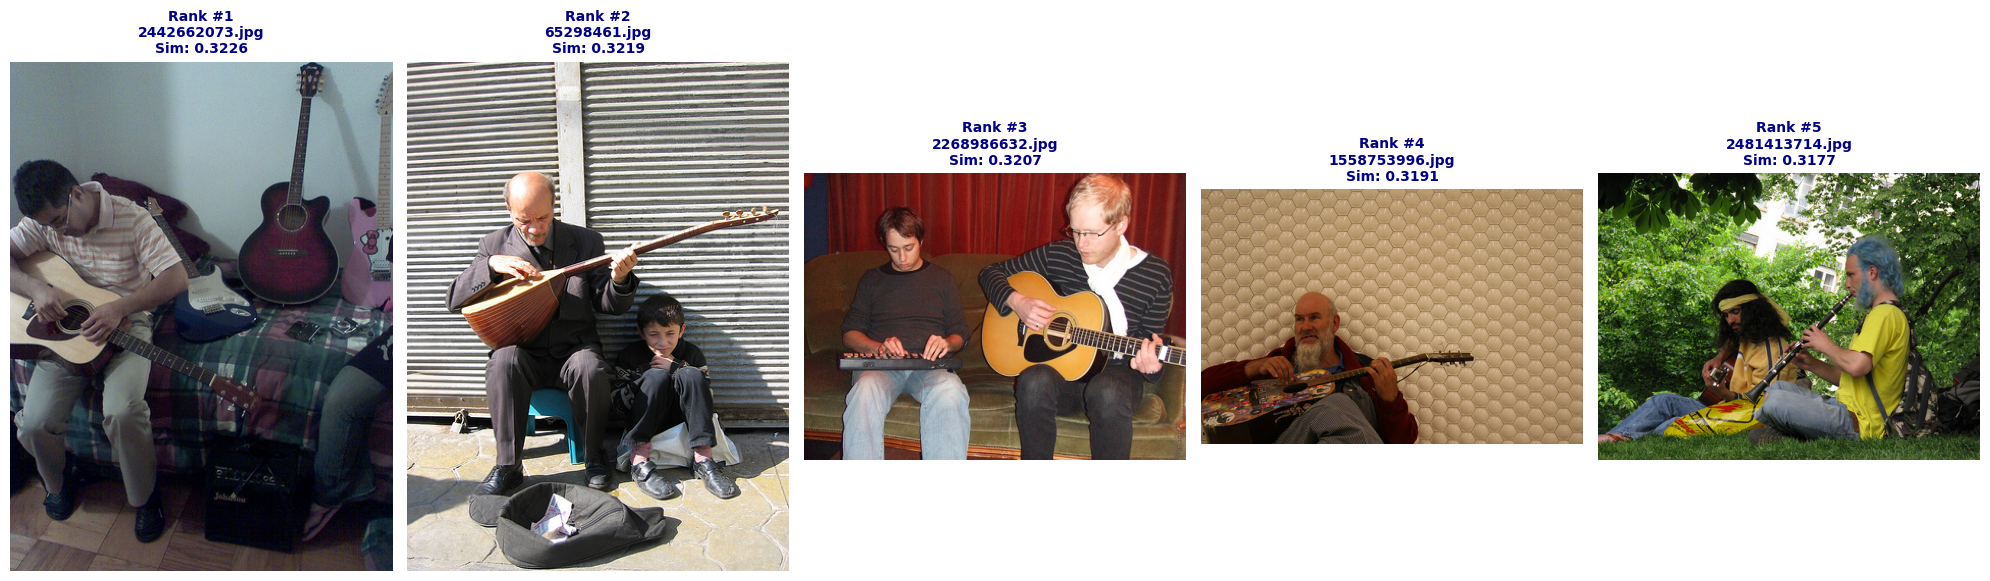


📊 DETAILED RETRIEVAL REPORT:


Rank        Filename Similarity Score  \
0     1  2442662073.jpg           0.3226   
1     2    65298461.jpg           0.3219   
2     3  2268986632.jpg           0.3207   
3     4  1558753996.jpg           0.3191   
4     5  2481413714.jpg           0.3177   

                 Ground Truth Caption (From Dataset)  
0   A young , college age man , is playing his in...  
1   An older man sitting on a blue stool playing ...  
2   A man is playing the guitar while on his righ...  
3   White Man with gray beard playing acoustic gu...  
4   Two men , one with blue hair and a blue beard...

In [11]:
# @title Uji Coba & Tampilan Top-K (Detailed Report & Visualization)
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os

# --- KONFIGURASI PENCARIAN ---
test_query = "Two men playing guitar"  # Ubah query di sini
K_VALUE = 5                            # Jumlah hasil

# 1. Helper Function: Mengambil Caption Asli dari Dataset (Untuk Detail)
def get_ground_truth(filename):
    try:
        # Membaca file captions jika belum ada di memori (atau gunakan df global)
        # Kita baca on-the-fly agar aman jika sel sebelumnya di-restart
        temp_df = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        temp_df.columns = [c.strip() for c in temp_df.columns]
        
        # Filter berdasarkan nama file
        subset = temp_df[temp_df['image'] == filename]['caption'].tolist()
        return subset[0] if subset else "[No Caption Found]"
    except Exception:
        return "[Metadata Error]"

print(f"🔎 PROCESSING QUERY: '{test_query}'")
print("-" * 80)

# 2. Eksekusi Retrieval (Vector Search)
query_vector = encoder.embed_text(test_query) 
retrieved_images, scores = vector_store.search(query_vector, k=K_VALUE)

# 3. Visualisasi Matplotlib (Grid View)
plt.figure(figsize=(20, 7)) # Canvas lebar

results_data = [] # Untuk menyimpan data tabel laporan

for rank, (img_filename, score) in enumerate(zip(retrieved_images, scores)):
    # A. Ambil Metadata (Detail)
    ground_truth_caption = get_ground_truth(img_filename)
    
    # B. Load Gambar
    try:
        img_path = os.path.join(Config.IMAGES_DIR, img_filename)
        image = Image.open(img_path).convert("RGB")
        
        # C. Plotting
        ax = plt.subplot(1, K_VALUE, rank + 1)
        plt.imshow(image)
        plt.axis("off")
        
        # Judul Gambar: Rank, Filename, Score
        title_text = f"Rank #{rank+1}\n{img_filename}\nSim: {score:.4f}"
        plt.title(title_text, fontsize=10, color='darkblue', fontweight='bold')
        
    except Exception as e:
        print(f"❌ Gagal render {img_filename}: {e}")

    # D. Simpan untuk Laporan Tabel
    results_data.append({
        "Rank": rank + 1,
        "Filename": img_filename,
        "Similarity Score": f"{score:.4f}",
        "Ground Truth Caption (From Dataset)": ground_truth_caption
    })

plt.tight_layout()
plt.show()

# 4. Laporan Detail (Tabular View)
print("\n📊 DETAILED RETRIEVAL REPORT:")
df_results = pd.DataFrame(results_data)
# Menampilkan tabel dataframe dengan styling sederhana (jika di Jupyter)
from IPython.display import display
display(df_results)

### **Evaluasi Kinerja Retrieval (Metrics)**

**Sesuai Penugasan Poin E:** *Matrix pengukuran performa (Recall@K)*.

**Deskripsi:**
Fungsi kualitatif untuk menguji performa sistem sebelum masuk ke tahap generatif. Ini membuktikan bahwa modul retrieval bekerja dengan benar.

--> Starting Evaluation on 100 random queries...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


📊 EVALUATION RESULTS (Recall@K):
----------------------------------------
   Recall@1: 17.00% (17/100 correct)
   Recall@5: 35.00% (35/100 correct)
   Recall@10: 41.00% (41/100 correct)
----------------------------------------


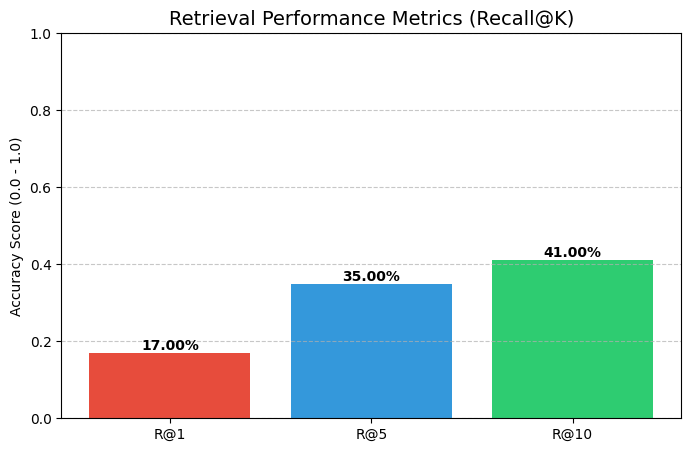

In [12]:
# @title Evaluasi Kuantitatif: Recall@K Metrics (Poin E)
import matplotlib.pyplot as plt
import seaborn as sns

class QuantitativeEvaluator:
    """
    Menghitung metrik standar industri untuk Image Retrieval: Recall@K.
    Mengukur seberapa sering gambar yang benar (Ground Truth) muncul dalam Top-K hasil pencarian.
    """
    def __init__(self, captions_file, vector_store, encoder):
        self.df = pd.read_csv(captions_file, on_bad_lines='skip')
        self.df.columns = [c.strip() for c in self.df.columns]
        self.vector_store = vector_store
        self.encoder = encoder
        
    def compute_metrics(self, sample_size=100, k_list=[1, 5, 10]):
        """
        Melakukan sampling random query dan mengecek posisi ranking gambar asli.
        """
        print(f"--> Starting Evaluation on {sample_size} random queries...")
        
        # 1. Sampling Data Uji
        # Kita ambil sampel acak dari caption yang ada
        test_sample = self.df.sample(n=sample_size, random_state=42)
        
        # Counter untuk setiap K
        hits = {k: 0 for k in k_list}
        max_k = max(k_list)
        
        # 2. Loop Evaluasi
        for _, row in tqdm(test_sample.iterrows(), total=sample_size, desc="Evaluating"):
            true_image = row['image']
            query_text = row['caption']
            
            # Embed Query
            q_vec = self.encoder.embed_text(query_text)
            
            # Search di Vector DB (Ambil sampai Max K)
            retrieved_imgs, _ = self.vector_store.search(q_vec, k=max_k)
            
            # Cek keberadaan Ground Truth di setiap level K
            for k in k_list:
                # Kita cek di irisan list sampai k
                if true_image in retrieved_imgs[:k]:
                    hits[k] += 1
                    
        # 3. Hitung Persentase (Recall Scores)
        results = {}
        print("\n📊 EVALUATION RESULTS (Recall@K):")
        print("-" * 40)
        for k in k_list:
            score = hits[k] / sample_size
            results[f"R@{k}"] = score
            print(f"   Recall@{k}: {score:.2%} ({hits[k]}/{sample_size} correct)")
        print("-" * 40)
            
        return results

    def visualize_results(self, metrics):
        """Membuat Plot Bar Chart untuk visualisasi performa."""
        plt.figure(figsize=(8, 5))
        keys = list(metrics.keys())
        vals = list(metrics.values())
        
        # Plotting
        bars = plt.bar(keys, vals, color=['#e74c3c', '#3498db', '#2ecc71'])
        
        # Styling
        plt.ylim(0, 1.0)
        plt.title(f"Retrieval Performance Metrics (Recall@K)", fontsize=14)
        plt.ylabel("Accuracy Score (0.0 - 1.0)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Menambah label angka di atas bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2%}',
                     ha='center', va='bottom', fontweight='bold')
            
        plt.show()

# --- EKSEKUSI EVALUASI ---
# Note: sample_size=100 untuk demo cepat. 
# Untuk hasil Final Project yang robust, naikkan menjadi 500 atau 1000.
evaluator = QuantitativeEvaluator(Config.CAPTIONS_FILE, vector_store, encoder)
metrics_result = evaluator.compute_metrics(sample_size=100, k_list=[1, 5, 10])

# Tampilkan Grafik
evaluator.visualize_results(metrics_result)

### **Komponen 4: Generative Component (Visual Bridge & LLM)**

**Sesuai Penugasan Poin 4:** *BLIP-2 (Captioning) & Llama 3 (Reasoning)*.

**Deskripsi:**
Kelas `GenerativeEngine` mengelola dua model berat:

1.  **BLIP-2:** Berperan sebagai "mata", mengubah citra hasil retrieval menjadi deskripsi tekstual.
2.  **Llama-3 (via Ollama):** Berperan sebagai "otak", menerima konteks deskripsi dari BLIP-2 dan pertanyaan user untuk menghasilkan jawaban naratif.

In [7]:
# @title Komponen 4: Multimodal Generative Engine (Fine-Tuned LoRA)
import requests
import os
import torch
from typing import List
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration
# [NEW] Import Library Adapter
from peft import PeftModel 

class GenerativeEngine:
    def __init__(self, caption_model: str, llm_api: str, device: str):
        self.device = device
        self.llm_api = llm_api
        
        print(f"--> Loading Base BLIP-2 Model: {caption_model}...")
        
        # 1. Load Base Model (Standar)
        self.blip_processor = Blip2Processor.from_pretrained(caption_model)
        
        # Load dengan float16 agar hemat VRAM
        base_model = Blip2ForConditionalGeneration.from_pretrained(
            caption_model, 
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None
        )
        
        # 2. [UPDATE PENTING] Cek & Load Fine-Tuned Adapter
        # Folder ada di direktori kerja saat ini (Notebook)
        ADAPTER_PATH = "./fine_tuned_blip2_adapter"
        
        if os.path.exists(ADAPTER_PATH):
            print(f"✅ FOUND FINE-TUNED ADAPTER! Merging weights from: {ADAPTER_PATH}")
            try:
                # Gabungkan Base Model + Adapter LoRA
                self.blip_model = PeftModel.from_pretrained(base_model, ADAPTER_PATH)
                print("🚀 Model berhasil di-upgrade ke Versi Fine-Tuned.")
            except Exception as e:
                print(f"⚠️ Gagal memuat adapter: {e}. Menggunakan model standar.")
                self.blip_model = base_model
        else:
            print("ℹ️ Adapter tidak ditemukan. Menggunakan model standar.")
            self.blip_model = base_model
        
    def image_to_text(self, image_paths: List[str]) -> List[str]:
        """
        Generate caption menggunakan model (Base atau Fine-Tuned).
        """
        captions = []
        print("    (Generating captions...)")
        
        for path in image_paths:
            # Handle path
            full_path = path if os.path.isabs(path) else os.path.abspath(os.path.join(Config.IMAGES_DIR, os.path.basename(path)))
            
            try:
                image = Image.open(full_path).convert('RGB')
                
                # Preprocess
                inputs = self.blip_processor(
                    images=image, 
                    return_tensors="pt"
                ).to(self.device, torch.float16 if self.device=="cuda" else torch.float32)
                
                # Generate dengan parameter optimal
                out_ids = self.blip_model.generate(
                    **inputs, 
                    max_new_tokens=50,      # Captioning tidak perlu terlalu panjang
                    min_length=15,          
                    num_beams=5,            # Beam Search untuk akurasi
                    repetition_penalty=1.2,
                    length_penalty=1.0, 
                    early_stopping=True
                )
                
                cap = self.blip_processor.batch_decode(out_ids, skip_special_tokens=True)[0].strip()
                captions.append(cap)
                
            except Exception as e:
                print(f"    ❌ Error on {os.path.basename(path)}: {e}")
                captions.append("Image error.")
                
        return captions

    def generate_answer(self, visual_contexts: List[str], user_query: str) -> str:
        """Mengirim data visual + pertanyaan ke Llama 3."""
        
        context_str = ""
        for i, ctx in enumerate(visual_contexts):
            context_str += f"- Image {i+1}: {ctx}\n"
            
        prompt = f"""
<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an intelligent visual assistant. Use the provided image descriptions to answer the user's question.

VISUAL CONTEXT:
{context_str}

USER QUERY: "{user_query}"

INSTRUCTIONS:
1. Answer directly based on the context.
2. If the context mentions specific details (colors, actions), include them.
3. Be concise.
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""
        
        payload = {"model": Config.LLM_MODEL, "prompt": prompt, "stream": False}
        
        try:
            resp = requests.post(self.llm_api, json=payload, timeout=120)
            if resp.status_code == 200:
                return resp.json().get("response", "Error: Empty response")
            return f"LLM Error: {resp.status_code}"
        except Exception as e:
            return f"Ollama Error: {str(e)}"

# Inisialisasi Ulang Engine
gen_engine = GenerativeEngine(Config.CAPTION_MODEL, Config.LLM_API, Config.DEVICE)

--> Loading Base BLIP-2 Model: Salesforce/blip2-opt-2.7b...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['query_tokens']
  warnings.warn(
Some parameters are on the meta device because they were offloaded to the cpu.


ℹ️ Adapter tidak ditemukan. Menggunakan model standar.


⚙️ Checking Encoder Dimensions...
   Dimension detected: 512
📂 Loading existing index from flickr30k_large.index...
✅ Index loaded successfully and dimensions match.

🎯 PROCESSING QUERY: 'Human playing musical instrument'
--------------------------------------------------
🔍 1. Searching Vector Database...
   --> Found 3 images.
🖼️ 2. Displaying Evidence...


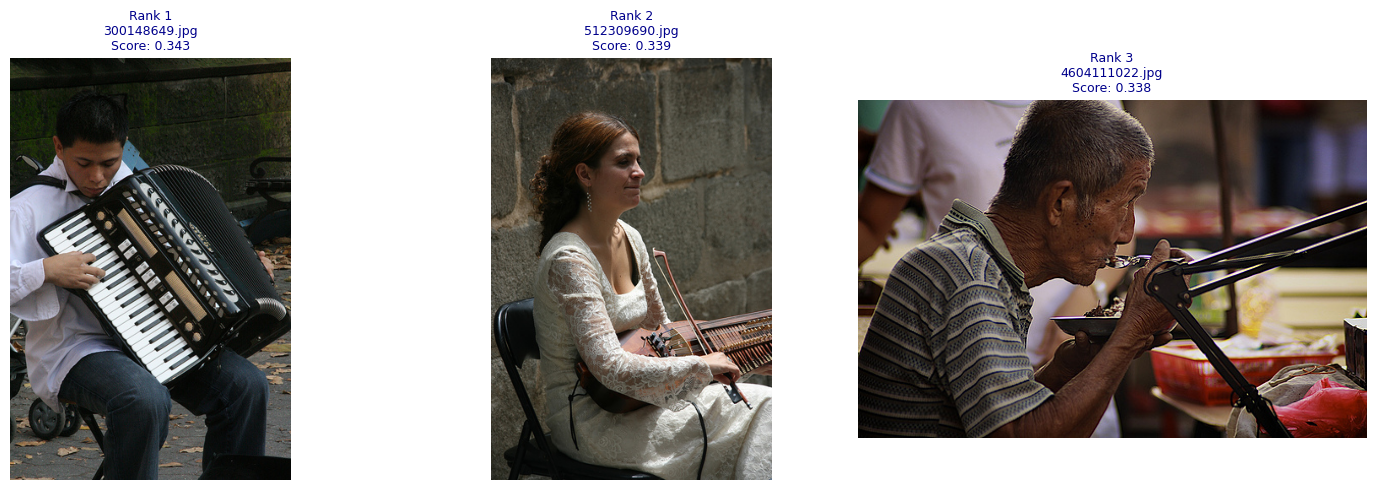

👁️ 3. Analyzing Images (BLIP-2)...
    (Generating captions...)
   [Image 1]: a man is sitting on a bench in front of a building
   [Image 2]: a woman in a white dress is sitting on a piano
   [Image 3]: an abstract image of a bird flying through the air
🧠 4. Generating Answer (Llama 3)...

🤖 FINAL AI RESPONSE:
Based on the visual context, I can answer that:

The human playing a musical instrument is the woman in Image 2, who is sitting on a piano.


In [8]:
# @title Vector Store (Auto-Fix) & Run Demo with Visualization
import faiss
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt # TAMBAHAN: Untuk visualisasi
from PIL import Image
from tqdm.auto import tqdm
from typing import List, Tuple

# 1. DEFINISI ULANG CLASS VECTOR STORE (Tetap Sama)
class VectorStore:
    def __init__(self, dimension: int):
        self.index = faiss.IndexFlatIP(dimension)
        self.metadata: List[str] = []
        
    def build_from_dataset(self, df: pd.DataFrame, encoder, batch_size: int = 16):
        print("--> Building Index...")
        filenames = df['image_filename'].tolist()
        
        # Cek dimensi encoder saat ini
        dummy = encoder.embed_text("test")
        current_dim = dummy.shape[1]
        
        if self.index.d != current_dim:
            print(f"   ♻️ Auto-correcting index dimension from {self.index.d} to {current_dim}...")
            self.index = faiss.IndexFlatIP(current_dim)
        else:
            self.index.reset()
            
        self.metadata = []
        
        for i in tqdm(range(0, len(filenames), batch_size), desc="Indexing"):
            batch_files = filenames[i : i + batch_size]
            batch_paths = [os.path.join(Config.IMAGES_DIR, f) for f in batch_files]
            
            emb = encoder.embed_images(batch_paths)
            if len(emb) > 0:
                self.index.add(emb.astype('float32'))
                self.metadata.extend(batch_files)
                
        self.save()
        print(f"✅ Index Built: {self.index.ntotal} vectors.")

    def search(self, query_vector: np.ndarray, k: int = 5) -> Tuple[List[str], List[float]]:
        distances, indices = self.index.search(query_vector.astype('float32'), k)
        results = []
        scores = []
        for idx, dist in zip(indices[0], distances[0]):
            if idx != -1:
                results.append(self.metadata[idx])
                scores.append(float(dist))
        return results, scores

    def save(self):
        faiss.write_index(self.index, Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'w') as f:
            json.dump(self.metadata, f)
            
    def load(self):
        self.index = faiss.read_index(Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'r') as f:
            self.metadata = json.load(f)

# 2. INISIALISASI & LOGIKA SMART LOAD
print("⚙️ Checking Encoder Dimensions...")
dummy_vec = encoder.embed_text("test")
REAL_DIM = dummy_vec.shape[1]
print(f"   Dimension detected: {REAL_DIM}")

vector_store = VectorStore(dimension=REAL_DIM)

# Cek index di disk
if os.path.exists(Config.INDEX_PATH) and os.path.exists(Config.METADATA_PATH):
    print(f"📂 Loading existing index from {Config.INDEX_PATH}...")
    try:
        vector_store.load()
        if vector_store.index.d != REAL_DIM:
            print(f"⚠️ Mismatch: Disk Index ({vector_store.index.d}) vs Encoder ({REAL_DIM})")
            print("   👉 Triggering Rebuild...")
            raise ValueError("Dimension Mismatch")
        else:
            print("✅ Index loaded successfully and dimensions match.")
    except Exception as e:
        print(f"🔧 Rebuilding Index due to: {str(e)}")
        vector_store.index = faiss.IndexFlatIP(REAL_DIM)
        
        if 'df_images' not in locals():
            df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
            df_images.columns = [c.strip() for c in df_images.columns]
            df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
        vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)
else:
    print("🔨 Index not found. Building new index...")
    if 'df_images' not in locals():
        df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        df_images.columns = [c.strip() for c in df_images.columns]
        df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
    vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)

# 3. JALANKAN RAG DEMO (DENGAN VISUALISASI)
def run_full_rag(user_query: str):
    print(f"\n🎯 PROCESSING QUERY: '{user_query}'")
    print("-" * 50)
    
    # A. Retrieval Phase
    print("🔍 1. Searching Vector Database...")
    q_vec = encoder.embed_text(user_query)
    retrieved_files, scores = vector_store.search(q_vec, k=3)
    
    if not retrieved_files:
        print("❌ No images found.")
        return

    print(f"   --> Found {len(retrieved_files)} images.")
    
    # [BARU] B. Tampilkan Gambar (Visualization)
    print("🖼️ 2. Displaying Evidence...")
    plt.figure(figsize=(15, 5))
    
    for i, (filename, score) in enumerate(zip(retrieved_files, scores)):
        try:
            img_path = os.path.join(Config.IMAGES_DIR, filename)
            img = Image.open(img_path).convert("RGB")
            
            # Plot
            ax = plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.axis('off')
            # Tampilkan Nama File & Score sebagai Judul
            plt.title(f"Rank {i+1}\n{filename}\nScore: {score:.3f}", fontsize=9, color='darkblue')
        except Exception as e:
            print(f"   ❌ Error display image {filename}: {e}")
            
    plt.tight_layout()
    plt.show()
    
    # C. Visual Understanding Phase
    print("👁️ 3. Analyzing Images (BLIP-2)...")
    visual_contexts = gen_engine.image_to_text(retrieved_files)
    
    for i, (img, ctx) in enumerate(zip(retrieved_files, visual_contexts)):
        print(f"   [Image {i+1}]: {ctx}")

    # D. Reasoning Phase
    print("🧠 4. Generating Answer (Llama 3)...")
    final_answer = gen_engine.generate_answer(visual_contexts, user_query)
    
    print("\n" + "="*50)
    print("🤖 FINAL AI RESPONSE:")
    print("="*50)
    print(final_answer)
    print("="*50)

# --- TEST RUN ---
run_full_rag("Human playing musical instrument")

⚙️ Checking Encoder Dimensions...
   Dimension detected: 512
📂 Loading existing index from flickr30k_large.index...
✅ Index loaded successfully and dimensions match.

🎯 PROCESSING QUERY: 'Human playing musical instrument'
--------------------------------------------------
 1. Searching Vector Database (Algorithm: Faiss IndexFlatIP / Cosine Sim)...
   --> Found 3 images.
📊 Calculating Cosine Similarity Matrix...


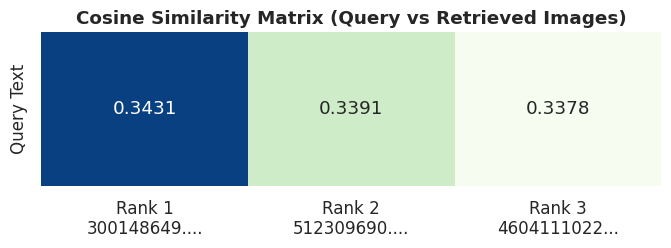

2. Visual Evidence:


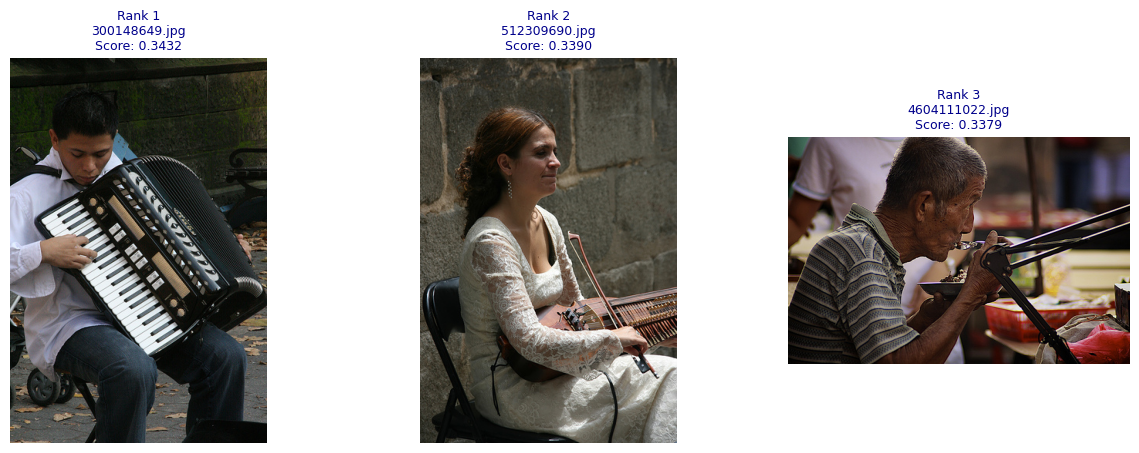

3. Analyzing Images (BLIP-2)...
    (Generating captions...)
   [Image 1]: a man is sitting on a bench in front of a building
   [Image 2]: a woman in a white dress is sitting on a piano
   [Image 3]: an abstract image of a bird flying through the air
🧠 4. Generating Answer (Llama 3)...

🤖 FINAL AI RESPONSE:
Based on the visual context, I can answer your question:

The user query is "Human playing musical instrument".

In Image 2: A woman in a white dress is sitting on a piano, which suggests that the human playing a musical instrument is a female playing the piano.


In [9]:
# @title Vector Store (Auto-Fix) & Demo with Similarity Matrix Visualization
import faiss
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm
from typing import List, Tuple

# 1. DEFINISI ULANG CLASS VECTOR STORE
class VectorStore:
    def __init__(self, dimension: int):
        self.index = faiss.IndexFlatIP(dimension)
        self.metadata: List[str] = []
        
    def build_from_dataset(self, df: pd.DataFrame, encoder, batch_size: int = 16):
        print("--> Building Index...")
        filenames = df['image_filename'].tolist()
        
        # Cek dimensi encoder saat ini
        dummy = encoder.embed_text("test")
        current_dim = dummy.shape[1]
        
        if self.index.d != current_dim:
            print(f"   ♻️ Auto-correcting index dimension from {self.index.d} to {current_dim}...")
            self.index = faiss.IndexFlatIP(current_dim)
        else:
            self.index.reset()
            
        self.metadata = []
        
        for i in tqdm(range(0, len(filenames), batch_size), desc="Indexing"):
            batch_files = filenames[i : i + batch_size]
            batch_paths = [os.path.join(Config.IMAGES_DIR, f) for f in batch_files]
            
            emb = encoder.embed_images(batch_paths)
            if len(emb) > 0:
                self.index.add(emb.astype('float32'))
                self.metadata.extend(batch_files)
                
        self.save()
        print(f"✅ Index Built: {self.index.ntotal} vectors.")

    def search(self, query_vector: np.ndarray, k: int = 5) -> Tuple[List[str], List[float]]:
        distances, indices = self.index.search(query_vector.astype('float32'), k)
        results = []
        scores = []
        for idx, dist in zip(indices[0], distances[0]):
            if idx != -1:
                results.append(self.metadata[idx])
                scores.append(float(dist))
        return results, scores

    def save(self):
        faiss.write_index(self.index, Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'w') as f:
            json.dump(self.metadata, f)
            
    def load(self):
        self.index = faiss.read_index(Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'r') as f:
            self.metadata = json.load(f)

# 2. INISIALISASI & LOGIKA SMART LOAD
print("⚙️ Checking Encoder Dimensions...")
dummy_vec = encoder.embed_text("test")
REAL_DIM = dummy_vec.shape[1]
print(f"   Dimension detected: {REAL_DIM}")

vector_store = VectorStore(dimension=REAL_DIM)

if os.path.exists(Config.INDEX_PATH) and os.path.exists(Config.METADATA_PATH):
    print(f"📂 Loading existing index from {Config.INDEX_PATH}...")
    try:
        vector_store.load()
        if vector_store.index.d != REAL_DIM:
            print(f"⚠️ Mismatch: Disk Index ({vector_store.index.d}) vs Encoder ({REAL_DIM})")
            print("   👉 Triggering Rebuild...")
            raise ValueError("Dimension Mismatch")
        else:
            print("✅ Index loaded successfully and dimensions match.")
    except Exception as e:
        print(f"🔧 Rebuilding Index due to: {str(e)}")
        vector_store.index = faiss.IndexFlatIP(REAL_DIM)
        
        if 'df_images' not in locals():
            df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
            df_images.columns = [c.strip() for c in df_images.columns]
            df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
        vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)
else:
    print("🔨 Index not found. Building new index...")
    if 'df_images' not in locals():
        df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        df_images.columns = [c.strip() for c in df_images.columns]
        df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
    vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)

# 3. FUNGSI VISUALISASI MATRIKS (Poin Penugasan: Vector Search Implementation)
def plot_similarity_matrix(query_vec, retrieved_paths, encoder):
    """
    Menampilkan Matriks Cosine Similarity (Heatmap) antara Query Teks dan Citra Hasil.
    """
    print("📊 Calculating Cosine Similarity Matrix...")
    
    # Re-Embed citra hasil
    retrieved_vecs = encoder.embed_images(retrieved_paths)
    
    # Hitung Dot Product (Cosine Similarity karena normalized)
    similarity_matrix = np.dot(query_vec, retrieved_vecs.T)
    
    # Plot Heatmap
    plt.figure(figsize=(8, 2))
    sns.set(font_scale=1.1)
    ax = sns.heatmap(
        similarity_matrix, 
        annot=True, 
        fmt=".4f", 
        cmap="GnBu", 
        cbar=False,
        xticklabels=[f"Rank {i+1}\n{os.path.basename(p)[:10]}..." for i, p in enumerate(retrieved_paths)],
        yticklabels=["Query Text"]
    )
    plt.title("Cosine Similarity Matrix (Query vs Retrieved Images)", fontweight='bold')
    plt.show()

# 4. JALANKAN RAG DEMO (DENGAN SEMUA VISUALISASI)
def run_full_rag(user_query: str):
    print(f"\n🎯 PROCESSING QUERY: '{user_query}'")
    print("-" * 50)
    
    # A. Retrieval Phase
    print(" 1. Searching Vector Database (Algorithm: Faiss IndexFlatIP / Cosine Sim)...")
    q_vec = encoder.embed_text(user_query)
    retrieved_files, scores = vector_store.search(q_vec, k=3)
    
    if not retrieved_files:
        print("❌ No images found.")
        return

    print(f"   --> Found {len(retrieved_files)} images.")
    full_paths = [os.path.join(Config.IMAGES_DIR, f) for f in retrieved_files]

    # B. Tampilkan Matriks Similaritas (Heatmap)
    try:
        plot_similarity_matrix(q_vec, full_paths, encoder)
    except Exception as e:
        print(f"   ⚠️ Could not plot matrix: {e}")

    # C. Tampilkan Gambar Fisik (Grid View)
    print("2. Visual Evidence:")
    plt.figure(figsize=(15, 5))
    for i, (path, score) in enumerate(zip(full_paths, scores)):
        try:
            img = Image.open(path).convert("RGB")
            plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Rank {i+1}\n{os.path.basename(path)}\nScore: {score:.4f}", fontsize=9, color='darkblue')
        except: pass
    plt.show()
    
    # D. Visual Understanding Phase
    print("3. Analyzing Images (BLIP-2)...")
    visual_contexts = gen_engine.image_to_text(retrieved_files)
    
    for i, (img, ctx) in enumerate(zip(retrieved_files, visual_contexts)):
        print(f"   [Image {i+1}]: {ctx}")

    # E. Reasoning Phase
    print("🧠 4. Generating Answer (Llama 3)...")
    final_answer = gen_engine.generate_answer(visual_contexts, user_query)
    
    print("\n" + "="*50)
    print("🤖 FINAL AI RESPONSE:")
    print("="*50)
    print(final_answer)
    print("="*50)

# --- TEST RUN ---
run_full_rag("Human playing musical instrument")

### **Komponen 5: User Interface (Streamlit Auto-Generator)**

**Sesuai Penugasan Poin 5:** *Web UI sederhana menggunakan Streamlit*.

**Lokasi Path :** User_Interface/app.py

In [ ]:
import streamlit as st
import os
import sys
import torch
import time
import pandas as pd
import numpy as np
import faiss
import requests
import gc
import json
from PIL import Image
from collections import defaultdict
from difflib import SequenceMatcher
from transformers import CLIPProcessor, CLIPModel, Blip2Processor, Blip2ForConditionalGeneration

# Library untuk PEFT (Fine-Tuning) & Metrik Akademis
from peft import PeftModel

# Import NLTK untuk BLEU Score
try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
except ImportError:
    import os
    os.system('pip install nltk')
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Import ROUGE untuk Metrik Tambahan (Opsional, fallback jika tidak ada)
try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
except ImportError:
    ROUGE_AVAILABLE = False

# --- 0. ENVIRONMENT SETUP ---
os.environ['HF_HOME'] = "/mnt/d/huggingface_cache" 

# --- PAGE CONFIGURATION ---
st.set_page_config(
    page_title="Multimodal RAG System",
    page_icon="🔬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# --- MEMORY MANAGEMENT ---
def clear_memory():
    """
    Forces garbage collection and clears CUDA cache to manage memory usage efficiently.
    Crucial for preventing OOM errors on GPUs with limited VRAM.
    """
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# --- CUSTOM CSS ---
st.markdown("""
    <style>
        .block-container {padding-top: 2rem; padding-bottom: 3rem;}
        h1 {font-family: 'Helvetica Neue', sans-serif; font-weight: 700; letter-spacing: -1px;}
        .stAlert {border-radius: 4px;}
        div[data-testid="stMetricValue"] {font-size: 1.4rem;}
        .img-caption {font-size: 0.8rem; color: #555;}
        .metric-card {background-color: #f0f2f6; padding: 15px; border-radius: 10px; margin-bottom: 10px;}
        .gt-caption {font-size: 0.85rem; color: #2e7d32; border-left: 2px solid #2e7d32; padding-left: 10px; margin-bottom: 5px;}
        footer {visibility: hidden;}
    </style>
""", unsafe_allow_html=True)

# --- 1. BACKEND CONFIGURATION ---
class Config:
    """
    Centralized configuration for file paths, model identifiers, and API endpoints.
    """
    BASE_DIR = os.path.abspath(os.path.join(os.path.dirname(__file__), ".."))
    IMAGES_DIR = os.path.join(BASE_DIR, "Dataset", "Images")
    CAPTIONS_FILE = os.path.join(BASE_DIR, "Dataset", "captions.txt")
    INDEX_PATH = os.path.join(BASE_DIR, "Notebook", "flickr30k_large.index") 
    METADATA_PATH = os.path.join(BASE_DIR, "Notebook", "metadata_large.json")
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    RETRIEVAL_MODEL = "openai/clip-vit-large-patch14"
    CAPTION_MODEL = "Salesforce/blip2-opt-2.7b"
    LLM_API_LOCAL = "http://localhost:11434/api/generate"
    LLM_API_WIN = "http://172.29.240.1:11434/api/generate"
    LLM_API = LLM_API_LOCAL 
    LLM_MODEL = "llama3" 

# --- 2. CORE CLASSES (SMART LOADER) ---

@st.cache_resource(show_spinner=False)
def load_captions_dataset():
    """
    Loads Ground Truth captions from CSV/TXT for validation purposes.
    Returns: defaultdict mapping image filenames to list of captions.
    """
    print(f"📂 Loading Captions from: {Config.CAPTIONS_FILE}")
    captions_dict = defaultdict(list)
    if not os.path.exists(Config.CAPTIONS_FILE):
        st.warning(f"⚠️ Captions file not found at {Config.CAPTIONS_FILE}")
        return captions_dict
    try:
        with open(Config.CAPTIONS_FILE, 'r', encoding='utf-8') as f:
            next(f) 
            for line in f:
                parts = line.strip().split(',', 1)
                if len(parts) == 2:
                    img_name, cap = parts
                    clean_cap = cap.strip().strip('"')
                    captions_dict[img_name].append(clean_cap)
        return captions_dict
    except Exception as e:
        st.error(f"Error reading captions file: {e}")
        return captions_dict

@st.cache_resource(show_spinner=False)
def load_retrieval_system():
    """
    Initializes CLIP Model and FAISS Index for semantic search.
    Handles dimension mismatch handling (512 vs 768 dim).
    """
    clear_memory()
    if not os.path.exists(Config.INDEX_PATH):
        st.error(f"⚠️ Index file missing at `{Config.INDEX_PATH}`.")
        return None, None, None
    try:
        index = faiss.read_index(Config.INDEX_PATH)
        disk_dim = index.d
        if disk_dim == 512:
            Config.RETRIEVAL_MODEL = "openai/clip-vit-base-patch32"
        elif disk_dim == 768:
            Config.RETRIEVAL_MODEL = "openai/clip-vit-large-patch14"
    except Exception as e:
        st.error(f"Error reading index: {e}")
        return None, None, None
    if not os.path.exists(Config.METADATA_PATH):
         st.error(f"Metadata json missing at {Config.METADATA_PATH}")
         return None, None, None
    with open(Config.METADATA_PATH, 'r') as f:
        metadata = json.load(f)
    print(f"Allocating Encoder: {Config.RETRIEVAL_MODEL}...")
    processor = CLIPProcessor.from_pretrained(Config.RETRIEVAL_MODEL)
    model = CLIPModel.from_pretrained(Config.RETRIEVAL_MODEL).to(Config.DEVICE)
    model.eval()
    return processor, model, (index, metadata)

@st.cache_resource(show_spinner=False)
def load_generative_system():
    """
    Initializes BLIP-2 Model for Image Captioning.
    Automatically detects and loads Fine-Tuned LoRA Adapter if available.
    """
    clear_memory()
    dtype = torch.float16 if Config.DEVICE == "cuda" else torch.float32
    
    print(f"Loading Base Gen Model: {Config.CAPTION_MODEL}...")
    
    # 1. Load Base Model
    processor = Blip2Processor.from_pretrained(Config.CAPTION_MODEL)
    model = Blip2ForConditionalGeneration.from_pretrained(
        Config.CAPTION_MODEL, torch_dtype=dtype
    ).to(Config.DEVICE)
    
    # 2. Check and Load Fine-Tuned Adapter (LoRA)
    ADAPTER_PATH = os.path.join(Config.BASE_DIR, "fine_tuned_blip2_adapter")
    
    if os.path.exists(ADAPTER_PATH):
        print(f"✅ FOUND FINE-TUNED ADAPTER! Loading from: {ADAPTER_PATH}")
        try:
            model = PeftModel.from_pretrained(model, ADAPTER_PATH)
            print("Successfully loaded Fine-Tuned BLIP-2.")
        except Exception as e:
            st.warning(f"⚠️ Failed to load adapter: {e}. Using base model.")
    else:
        print("ℹ️ No adapter found. Using standard base model.")
        
    return processor, model

# --- 3. HELPER FUNCTIONS ---

def perform_retrieval(query_text, clip_processor, clip_model, vector_db, k=5):
    """
    Executes dense vector retrieval using CLIP embeddings and FAISS.
    """
    index, metadata = vector_db
    text_with_prompt = [f"A photo of {query_text}"]
    inputs = clip_processor(text=text_with_prompt, return_tensors="pt", padding=True).to(Config.DEVICE)
    with torch.no_grad():
        features = clip_model.get_text_features(**inputs)
        features = features / features.norm(p=2, dim=-1, keepdim=True)
    q_vec = features.cpu().numpy().astype('float32')
    distances, indices = index.search(q_vec, k)
    results = []
    for idx, dist in zip(indices[0], distances[0]):
        if idx != -1:
            results.append({
                "filename": metadata[idx],
                "score": float(dist),
                "path": os.path.join(Config.IMAGES_DIR, metadata[idx])
            })
    del inputs, features, q_vec
    clear_memory()
    return results

def generate_context(images_data, blip_processor, blip_model):
    """
    Generates visual descriptions using BLIP-2.
    Uses safe generation parameters to avoid OOM on limited hardware.
    """
    contexts = []
    dtype = torch.float16 if Config.DEVICE == "cuda" else torch.float32
    for item in images_data:
        try:
            img_path = item['path']
            if not os.path.isabs(img_path): img_path = os.path.abspath(img_path)
            raw_image = Image.open(img_path).convert('RGB')
            inputs = blip_processor(images=raw_image, return_tensors="pt").to(Config.DEVICE, dtype)
            
            with torch.no_grad():
                out = blip_model.generate(
                    **inputs, max_new_tokens=100, min_length=15,
                    do_sample=True, top_p=0.90, temperature=0.6,
                    repetition_penalty=1.2, num_return_sequences=5 
                )
            
            all_candidates = blip_processor.batch_decode(out, skip_special_tokens=True)
            unique_captions = []
            for cap in all_candidates:
                clean_cap = cap.strip()
                if not clean_cap: continue
                is_duplicate = False
                for existing in unique_captions:
                    similarity = SequenceMatcher(None, clean_cap.lower(), existing.lower()).ratio()
                    if similarity > 0.8: 
                        is_duplicate = True
                        break
                if not is_duplicate: unique_captions.append(clean_cap)
            
            if not unique_captions: unique_captions = ["Image content unclear."]
            main_paragraph = unique_captions[0]
            remaining_points = unique_captions[1:] 
            if remaining_points:
                bullet_points = "\n".join([f"• {cap}" for cap in remaining_points])
                final_text = f"{main_paragraph}\n\n{bullet_points}"
            else:
                final_text = main_paragraph
            contexts.append(final_text)
            del inputs, out, raw_image
            clear_memory()
        except Exception as e:
            contexts.append(f"[Error: {str(e)}]")
            clear_memory()
    return contexts

def check_ollama_status():
    """Checks availability of the Local LLM API."""
    urls = [Config.LLM_API_LOCAL, Config.LLM_API_WIN]
    for url in urls:
        try:
            test_url = url.replace("/generate", "/tags")
            resp = requests.get(test_url, timeout=1)
            if resp.status_code == 200: return True, url
        except: continue
    return False, None

def query_llm(context_list, user_query, api_url):
    """
    Orchestrates the Reasoning Phase using Llama-3.
    Constructs a structured prompt for data auditing.
    """
    full_report = ""
    progress_bar = st.progress(0, text="🕵️ Llama-3 is auditing evidence...")
    
    for i, context_item in enumerate(context_list):
        rank = i + 1
        progress_bar.progress((i + 1) / len(context_list), text=f"Auditing Rank {rank}/{len(context_list)}...")
        
        prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are a Strict Data Auditor. Verify if ONE specific image matches the User Query based on provided evidence.
GOLDEN RULES:
1. TRUST DATASET FACTS (Ground Truth).
2. IF FACTS CONFIRM QUERY DETAILS -> MATCH.
3. IF FACTS CONTRADICT -> NO MATCH.
OUTPUT FORMAT:
**RANK {rank} Analysis:**
- **Verdict:** [MATCH / PARTIAL / NO MATCH]
- **Audit:**
  - Query asked for: "[Keyword]"
  - Dataset Facts say: "[Quote Fact]"
  - AI Vision says: "[Quote Vision]"
- **Conclusion:** [Reasoning]
CONTEXT DATA:
{context_item}
<|eot_id|><|start_header_id|>user<|end_header_id|>
Query: "{user_query}"
<|eot_id|><|start_header_id|>assistant<|end_header_id|>"""

        payload = {
            "model": Config.LLM_MODEL, 
            "prompt": prompt, 
            "stream": False,
            "options": {"num_predict": 512, "temperature": 0.0, "top_p": 1.0}
        }
        
        def send_request():
            return requests.post(api_url, json=payload, timeout=120)

        try:
            response = send_request()
            if response.status_code == 500:
                time.sleep(1); response = send_request()
            
            if response.status_code == 200:
                full_report += response.json().get("response", "").strip() + "\n\n" + ("-"*40) + "\n\n"
            elif response.status_code == 404:
                full_report += f"**RANK {rank}:** Error - Model not found.\n\n"
            else:
                full_report += f"**RANK {rank}:** Error - API Failure.\n\n"
        except Exception as e:
            full_report += f"**RANK {rank}:** Connection Error: {e}\n\n"
    
    progress_bar.empty()
    return full_report

def calculate_rag_metrics(user_query, generated_answer, retrieved_contexts, clip_processor, clip_model):
    """
    Calculates RAG Quality Metrics using CLIP Latent Space embeddings.
    
    Metrics:
    1. Answer Relevance: Cosine Similarity between (User Query) and (LLM Answer).
    2. Faithfulness: Cosine Similarity between (Visual Context) and (LLM Answer).
    
    Returns: (relevance_score, faithfulness_score)
    """
    try:
        # Clean markdown artifacts from answer
        clean_answer = generated_answer.replace("*", "").replace("#", "").strip()
        
        # Aggregate visual contexts into one string
        context_text = " ".join([ctx.split('\n')[0] for ctx in retrieved_contexts]) 
        
        # Prepare inputs (Truncate to 77 tokens to fit CLIP context window)
        texts = [
            user_query,    # Index 0
            clean_answer,  # Index 1
            context_text   # Index 2
        ]
        
        inputs = clip_processor(
            text=texts, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=77
        ).to(Config.DEVICE)
        
        with torch.no_grad():
            feats = clip_model.get_text_features(**inputs)
            feats = feats / feats.norm(p=2, dim=-1, keepdim=True)
            
            # 1. Answer Relevance (Query vs Answer)
            relevance = torch.nn.functional.cosine_similarity(feats[0], feats[1], dim=0).item()
            
            # 2. Faithfulness (Context vs Answer)
            faithfulness = torch.nn.functional.cosine_similarity(feats[2], feats[1], dim=0).item()
            
        return relevance, faithfulness
    except Exception as e:
        print(f"RAG Metric Error: {e}")
        return 0.0, 0.0

def calculate_caption_metrics(reference_texts, candidate_text):
    """
    Calculates Generation Metrics: BLEU-4 and ROUGE-L.
    
    Args:
        reference_texts (list of list of str): Tokenized ground truth captions.
        candidate_text (list of str): Tokenized generated caption.
        
    Returns:
        dict: Containing 'bleu4' and 'rougeL' scores.
    """
    metrics = {"bleu4": 0.0, "rougeL": 0.0}
    
    # 1. BLEU-4
    try:
        if reference_texts and candidate_text:
            chencherry = SmoothingFunction()
            metrics["bleu4"] = sentence_bleu(reference_texts, candidate_text, smoothing_function=chencherry.method1)
    except: pass
    
    # 2. ROUGE-L (Using simple implementation if library missing or wrapper)
    try:
        if ROUGE_AVAILABLE:
            scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
            # Join tokens back to string for ROUGE
            ref_str = " ".join(reference_texts[0]) 
            cand_str = " ".join(candidate_text)
            scores = scorer.score(ref_str, cand_str)
            metrics["rougeL"] = scores['rougeL'].fmeasure
    except: pass
    
    return metrics

# --- 4. MAIN UI LAYOUT ---

def main():
    with st.sidebar:
        st.header("Configuration")
        top_k = st.slider("Retrieval Count (K)", min_value=1, max_value=10, value=3)
        st.markdown("---")
        with st.expander("📐 Vector Search Method", expanded=True):
            st.markdown("""
            **Metric:** Cosine Similarity
            **Formula:**
            $$
            \\text{Sim}(A, B) = \\frac{A \\cdot B}{\\|A\\| \\|B\\|}
            $$
            """)
        st.markdown("---")
        if st.button("🧹 Flush RAM/VRAM"):
            clear_memory(); st.toast("Memory cleared!", icon="🧹")
        st.divider()
        with st.status("System Status", expanded=True) as status:
            gt_captions = load_captions_dataset()
            st.success(f"✅ Captions Loaded ({len(gt_captions)} items)")
            clip_proc, clip_model, vector_db = load_retrieval_system()
            if vector_db: st.success(f"✅ Retrieval Ready")
            else: st.stop()
            blip_proc, blip_model = load_generative_system()
            st.success("✅ Generative Ready")
            ollama_ok, working_url = check_ollama_status()
            if ollama_ok:
                st.success(f"✅ Llama-3 Connected")
                Config.LLM_API = working_url 
            else: st.warning("⚠️ Ollama Offline")
            status.update(label="System Operational", state="complete", expanded=False)
        st.info("**About:** Multimodal RAG System using Flickr30k.")

    st.title("Multimodal RAG System")
    st.markdown("##### A RAG-Based Approach to Image Retrieval and Context-Aware Generation")
    
    query = st.text_input("Enter your visual query:", placeholder="e.g., Two men playing guitar...")
    run_btn = st.button("Run Analysis", type="primary", use_container_width=True)

    if run_btn and query:
        if not query.strip(): st.warning("Please enter a valid query."); return
        clear_memory()
        start_time = time.time()
        
        # 1. RETRIEVAL PHASE
        with st.spinner("🔍 Searching Vector Database..."):
            results = perform_retrieval(query, clip_proc, clip_model, vector_db, k=top_k)

        # METRICS: GT Match Rate Calculation
        scores = [r['score'] for r in results]
        relevant_count = 0
        query_words = set(query.lower().split())
        
        for item in results:
            fname = item['filename']
            is_relevant = False
            if fname in gt_captions:
                for cap in gt_captions[fname]:
                    cap_words = set(cap.lower().split())
                    overlap = len(query_words.intersection(cap_words))
                    if len(query_words) > 0 and (overlap / len(query_words) >= 0.5):
                        is_relevant = True
                        break
            if is_relevant: relevant_count += 1
        
        gt_match_rate = relevant_count / len(results) if results else 0

        # DISPLAY RETRIEVAL METRICS
        st.markdown("### Performance Metrics")
        m1, m2, m3, m4 = st.columns(4)
        m1.metric("Retrieval Latency", f"{(time.time()-start_time)*1000:.1f} ms")
        if scores: m2.metric(f"Sim Score Range", f"{scores[0]:.3f} - {scores[-1]:.3f}")
        else: m2.metric("Sim Score", "0.000")
        m3.metric(f"Avg Sim (Top-{top_k})", f"{np.mean(scores):.4f}")
        m4.metric(f"GT Match (Top-{top_k})", f"{gt_match_rate:.0%}", help="Precision based on Ground Truth matching")
        st.divider()

        col_left, col_right = st.columns([1.2, 1])

        # 2. EVIDENCE DISPLAY
        with col_left:
            st.subheader(f"Evidence (Top-{top_k})")
            tabs = st.tabs([f"Rank {i+1}" for i in range(len(results))])
            for i, (tab, item) in enumerate(zip(tabs, results)):
                with tab:
                    try:
                        img = Image.open(item['path'])
                        st.image(img, use_container_width=True)
                        fname = item['filename']
                        st.markdown("**📂 Ground Truth Captions:**")
                        if fname in gt_captions:
                            with st.container(height=150, border=True):
                                for cap in gt_captions[fname]:
                                    st.markdown(f"<div class='gt-caption'>• {cap}</div>", unsafe_allow_html=True)
                        else: st.caption("No ground truth found.")
                        with st.expander("See Metadata"):
                            st.code(f"File: {fname}\nScore: {item['score']:.4f}")
                    except Exception as e: st.error(f"Image error: {e}")

        # 3. GENERATION & REASONING PHASE
        with col_right:
            st.subheader("Context-Aware Generation")
            with st.status("Processing...", expanded=True) as gen_status:
                st.write("BLIP-2: Analyzing Visuals...")
                visual_contexts = generate_context(results, blip_proc, blip_model)
                
                st.write("Data Fusion: Merging Vision + Dataset Facts...")
                rich_context_for_llm = []
                for i, blip_text in enumerate(visual_contexts):
                    fname = results[i]['filename']
                    gt_text = "(No verified data available)"
                    if fname in gt_captions:
                        gt_list = gt_captions[fname][:10]
                        gt_text = "\n".join([f"- {c}" for c in gt_list])
                    combined_entry = (
                        f"=== IMAGE #{i+1} (Rank {i+1}) ===\n"
                        f"[AI Vision / BLIP-2 Output]:\n{blip_text}\n\n"
                        f"[Dataset Facts / Ground Truth]:\n{gt_text}\n"
                        f"====================================="
                    )
                    rich_context_for_llm.append(combined_entry)

                st.write("Llama-3: Auditing Evidence...")
                if ollama_ok:
                    gen_start = time.time()
                    final_answer = query_llm(rich_context_for_llm, query, Config.LLM_API)
                    gen_latency = time.time() - gen_start
                    
                    # [METRIC CALCULATION] RAG Metrics
                    rag_relevance, rag_faithfulness = calculate_rag_metrics(
                        query, final_answer, visual_contexts, clip_proc, clip_model
                    )
                else: 
                    final_answer = "⚠️ Ollama error."; gen_latency = 0
                    rag_relevance, rag_faithfulness = 0.0, 0.0
                
                gen_status.update(label="Done", state="complete", expanded=False)
            
            # Display Final Answer & RAG Metrics
            with st.expander("View AI Response (Llama-3 Audit)", expanded=True):
                if "Error" in final_answer: st.error(final_answer)
                else: st.markdown(final_answer)
                st.divider()
                
                # Display RAG Metrics
                rm1, rm2, rm3 = st.columns(3)
                rm1.caption(f"Latency: {gen_latency:.2f}s")
                rm2.metric("Answer Relevance", f"{rag_relevance:.4f}", help="Semantic Similarity (Query vs Answer)")
                rm3.metric("Faithfulness", f"{rag_faithfulness:.4f}", help="Semantic Similarity (Evidence vs Answer)")
            
            # Display Generation Metrics (BLEU & ROUGE)
            # [FITUR UTAMA: AKADEMIS METRIC UNTUK CAPTIONING (BLEU & ROUGE)]
            with st.expander("View Generated Visual Contexts & Metrics", expanded=False):
                st.info("ℹ️ **Captioning Metrics:** Evaluasi seberapa mirip deskripsi AI dengan deskripsi Manusia (Ground Truth).")
                
                for idx, ctx in enumerate(visual_contexts):
                    fname = results[idx]['filename']
                    
                    # 1. Hitung Metrik
                    metrics = {"bleu4": 0.0, "rougeL": 0.0}
                    if fname in gt_captions:
                        references = [c.lower().split() for c in gt_captions[fname]]
                        candidate = ctx.split('\n')[0].lower().split()
                        metrics = calculate_caption_metrics(references, candidate)

                    # 2. Tampilkan Layout
                    c1, c2 = st.columns([3, 1])
                    
                    with c1:
                        st.markdown(f"**Img {idx+1} ({fname}):**")
                        st.text(ctx) # Tampilkan teks caption AI
                        
                    with c2:
                        # --- BLEU-4 METRIC ---
                        # Tentukan warna status BLEU
                        b_score = metrics['bleu4']
                        if b_score > 0.30: b_label = "Excellent 🟢"
                        elif b_score > 0.15: b_label = "Good 🟡"
                        else: b_label = "Low 🔴"
                        
                        st.metric(
                            label="BLEU-4 (Precision)", 
                            value=f"{b_score:.4f}", 
                            help="Mengukur akurasi urutan kata (n-gram). Seberapa tepat kata-kata yang dipilih AI dibandingkan referensi manusia."
                        )
                        st.caption(f"Status: **{b_label}**")
                        
                        st.divider() 
                        
                        r_score = metrics['rougeL']
                        if r_score > 0.35: r_label = "Excellent 🟢"
                        elif r_score > 0.20: r_label = "Good 🟡"
                        else: r_label = "Low 🔴"

                        st.metric(
                            label="ROUGE-L (Recall)", 
                            value=f"{r_score:.4f}",
                            help="Mengukur kelengkapan struktur kalimat (LCS). Seberapa lengkap informasi/frasa yang tertangkap dibandingkan referensi manusia."
                        )
                        st.caption(f"Status: **{r_label}**") 

                    st.divider() 

        st.divider()
        st.caption(f"Total Time: {time.time() - start_time:.2f}s")
        clear_memory()

if __name__ == "__main__":
    main()